# Surface Reconstruction from Field Measurement
### Chengyu Wang, Duke University

Data are generated from 3d models (STL files).

In [1]:
from tensorflow import keras
import tensorflow as tf
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# ## model 1  input:(512,512,2)

# def down_layer(n_filter,s_filter,strides,x):
#     x = keras.layers.Conv2D(n_filter,s_filter,strides=strides,activation='sigmoid')(x)
#     x = keras.layers.Conv2D(128,3,strides=1,padding='same',activation='sigmoid')(x)
#     return x

# def up_layer(n_filter,s_filter,strides,x):
#     x = keras.layers.Conv2DTranspose(n_filter,s_filter,strides=strides,activation='sigmoid')(x)
#     x = keras.layers.Conv2D(128,3,strides=1,padding='same',activation='sigmoid')(x)
#     return x

# inputs = keras.Input(shape = (512,512,2))
# x1 = down_layer(128,11,3,inputs)
# x2 = down_layer(128,9,3,x1)
# x3 = down_layer(128,3,3,x2)
# x4 = down_layer(128,3,3,x3)
# x4_ = keras.layers.Conv2D(128,3,strides=1,padding='same',activation='sigmoid')(x4)
# x3_ = up_layer(128,3,3,x4_)
# x3_ = keras.layers.concatenate([x3,x3_])
# x2_ = up_layer(128,3,3,x3_)
# x2_ = keras.layers.concatenate([x2,x2_])
# x1_ = up_layer(128,9,3,x2_)
# x1_ = keras.layers.concatenate([x1,x1_])
# x0_ = keras.layers.Conv2DTranspose(64,11,strides=3,activation='sigmoid')(x1_)
# x = keras.layers.Conv2D(64,3,padding='same',activation='sigmoid')(x0_)
# x = keras.layers.Conv2D(1,3,padding='same')(x)
# model = keras.Model(inputs = inputs, outputs = x)

# ## model 2  input:(512,512,2)
# def down_layer(n_filter,s_filter,strides,x):
#     x = keras.layers.Conv2D(n_filter,s_filter,strides=strides,activation='sigmoid')(x)
#     x = keras.layers.Conv2D(16,3,strides=1,padding='same',activation='sigmoid')(x)
#     return x

# def up_layer(n_filter,s_filter,strides,x):
#     x = keras.layers.Conv2DTranspose(n_filter,s_filter,strides=strides,activation='sigmoid')(x)
#     x = keras.layers.Conv2D(16,3,strides=1,padding='same',activation='sigmoid')(x)
#     return x

# inputs = keras.Input(shape = (512,512,2))
# x1 = down_layer(16,11,3,inputs)
# x2 = down_layer(16,9,3,x1)
# x3 = down_layer(16,3,3,x2)
# x4 = down_layer(16,3,3,x3)
# x4_ = keras.layers.Conv2D(16,3,strides=1,padding='same',activation='sigmoid')(x4)
# x3_ = up_layer(16,3,3,x4_)
# x3_ = keras.layers.concatenate([x3,x3_])
# x2_ = up_layer(16,3,3,x3_)
# x2_ = keras.layers.concatenate([x2,x2_])
# x1_ = up_layer(16,9,3,x2_)
# x1_ = keras.layers.concatenate([x1,x1_])
# x0_ = keras.layers.Conv2DTranspose(64,11,strides=3,activation='sigmoid')(x1_)
# x = keras.layers.Conv2D(64,3,padding='same',activation='sigmoid')(x0_)
# x = keras.layers.Conv2D(1,3,padding='same')(x)
# model = keras.Model(inputs = inputs, outputs = x)

## model 3  input:(256,256,2)
inputs = keras.Input(shape = (256,256,2))
x1 = keras.layers.Conv2D(64,13,strides=3,activation='sigmoid')(inputs)
x2 = keras.layers.Conv2D(64,7,strides=3,activation='sigmoid')(x1)
x3 = keras.layers.Conv2D(64,5,strides=3,activation='sigmoid')(x2)
x3 = keras.layers.Conv2D(64,1,strides=1,activation='sigmoid')(x3)

x2_ = keras.layers.Conv2DTranspose(64,5,strides=3,activation='sigmoid')(x3)
x2_ = keras.layers.concatenate([x2,x2_])
x1_ = keras.layers.Conv2DTranspose(64,7,strides=3,activation='sigmoid')(x2_)
x1_ = keras.layers.concatenate([x1,x1_])
x = keras.layers.Conv2DTranspose(64,13,strides=3,activation='sigmoid')(x1_)
x = keras.layers.Conv2D(64,3,padding='same',activation='sigmoid')(x)
x = keras.layers.Conv2D(1,3,padding='same')(x)
model = keras.Model(inputs = inputs, outputs = x)

In [3]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 2) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 82, 82, 64)   21696       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 26, 26, 64)   200768      conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 8, 64)     102464      conv2d_1[0][0]                   
______________________________________________________________________________________________

In [4]:
log_dir = "logs/logs3/" 
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir,profile_batch=0)

In [5]:
optim = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optim,
             loss = 'mse')

In [6]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, path_to_files, batch_size=1, dim=(512,512), shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.on_epoch_end()
        self.path = path_to_files

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size, self.dim[0],self.dim[1], 2))
        y = np.zeros((self.batch_size, self.dim[0],self.dim[1], 1))

#         # Generate data
#         for i, ID in enumerate(list_IDs_temp):
            
#             m = sio.loadmat(self.path + '/{}.mat'.format(ID))['field']
#             X[i,:,:,0] = np.abs(m) * 7.0 ## approximately between [0,1]
#             X[i,:,:,1] = (np.angle(m/np.angle(m[0,0])) + np.pi)/(2*np.pi) ## between [0,1]
            
#             gt = sio.loadmat(self.path + '/{}.mat'.format(ID))['depth']
#             y[i,:,:,0] = gt/300.0  ## approximately between [0,1]
#         return X, y
    
        # Generate data
#         for i, ID in enumerate(list_IDs_temp):
            
#             m = sio.loadmat(self.path + '/{}.mat'.format(ID))['field']
#             m = m / np.angle(m[0,0])
#             X[i,:,:,0] = np.real(m) * 10.0 ## approximately between [0,1]
#             X[i,:,:,1] = np.imag(m) * 10.0 ## approximately between [0,1]
            
#             gt = sio.loadmat(self.path + '/{}.mat'.format(ID))['depth']
#             y[i,:,:,0] = gt/300.0  ## approximately between [0,1]


        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            m = sio.loadmat(self.path + '/{}.mat'.format(ID))['field']
            # Input is normalized to [0,1]
            m = m / np.angle(m[0,0])
            m = m / np.max(abs(m))
            
            X[i,:,:,0] = np.real(m)
            X[i,:,:,1] = np.imag(m)
            
            gt = sio.loadmat(self.path + '/{}.mat'.format(ID))['depth']
            y[i,:,:,0] = gt/600.0  ## approximately between [0,1]
        return X, y
    
    
      

In [14]:
train_list = list(range(850))
# test_list = list(range(15,25))
training_generator = DataGenerator(train_list,'field_data2/',batch_size=5,dim=(256,256))
# validation_generator = DataGenerator(test_list,'field_data/',batch_size=5)

In [10]:
model.fit(training_generator,verbose = 0,epochs = 10000,#validation_data=validation_generator,
          use_multiprocessing=True,callbacks=[tensorboard_callback])

In [ ]:
model.fit(training_generator,verbose = 0,initial_epoch=10000,epochs = 100000,#validation_data=validation_generator,
          use_multiprocessing=True,callbacks=[tensorboard_callback])

In [47]:
model.save('model/model3')

INFO:tensorflow:Assets written to: model/model2/assets


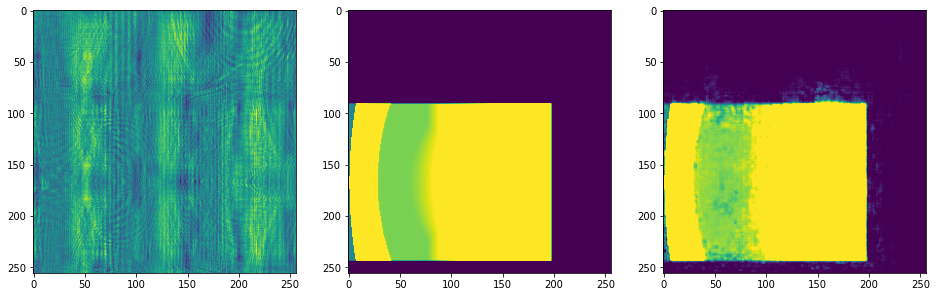

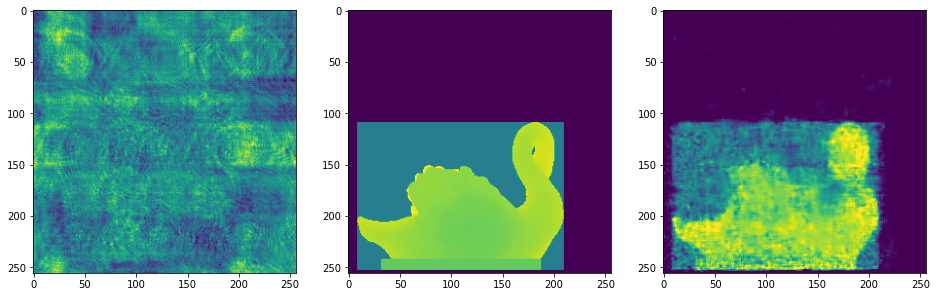

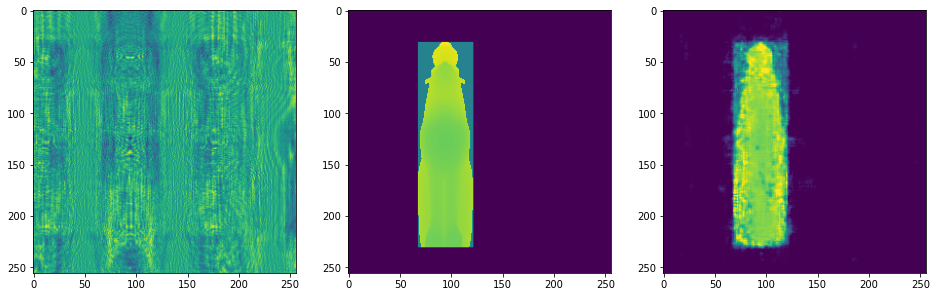

In [29]:
for ID in range(3):

    X = np.zeros((1, 256,256, 2))
    y = np.zeros((1, 256,256, 1))

    m = sio.loadmat('field_data2/' + '{}.mat'.format(ID))['field']
    m = m / np.angle(m[0,0])
    m = m / np.max(abs(m))
    X[0,:,:,0] = np.real(m)
    X[0,:,:,1] = np.imag(m) 

    gt = sio.loadmat('field_data2/' + '{}.mat'.format(ID))['depth']
    y[0,:,:,0] = gt/600.0  

    tmp = model.predict(X)

    plt.figure(figsize=(16,8))
    plt.subplot(1,3,1)
    plt.imshow(X[0,:,:,0])
    # plt.show()

    plt.subplot(1,3,2)
    plt.imshow(y[0,:,:,0],vmin = 0,vmax = 0.5)
    # plt.colorbar()
    # plt.show()

    plt.subplot(1,3,3)
    plt.imshow(tmp[0,:,:,0],vmin = 0,vmax = 0.5)
    # plt.colorbar()
    plt.show()

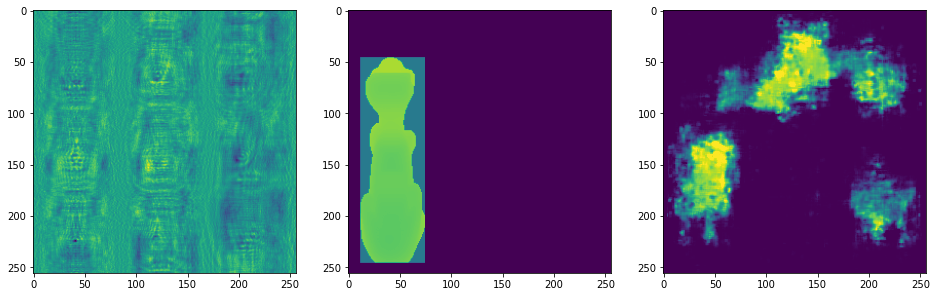

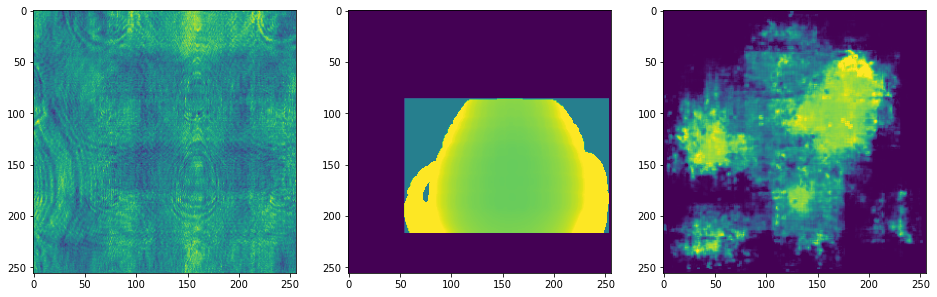

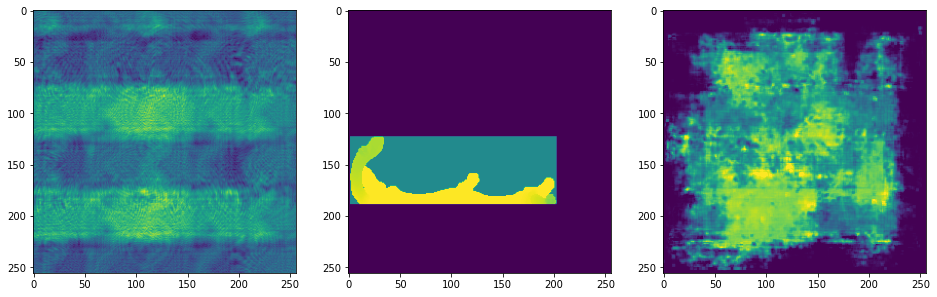

In [30]:
for ID in range(1000,1003):

    X = np.zeros((1, 256,256, 2))
    y = np.zeros((1, 256,256, 1))

#     m = sio.loadmat('field_data/' + '/{}.mat'.format(ID))['field']
#     X[0,:,:,0] = np.abs(m) * 7.0 ## approximately between [0,1]
#     X[0,:,:,1] = (np.angle(m/np.angle(m[0,0])) + np.pi)/(2*np.pi) ## between [0,1]

    m = sio.loadmat('field_data2/' + '{}.mat'.format(ID))['field']
    m = m / np.angle(m[0,0])
    m = m / np.max(abs(m))
    X[0,:,:,0] = np.real(m)
    X[0,:,:,1] = np.imag(m) 

    gt = sio.loadmat('field_data2/' + '{}.mat'.format(ID))['depth']
    y[0,:,:,0] = gt/600.0  

    tmp = model.predict(X)

    plt.figure(figsize=(16,8))
    plt.subplot(1,3,1)
    plt.imshow(X[0,:,:,0])
    # plt.show()

    plt.subplot(1,3,2)
    plt.imshow(y[0,:,:,0],vmin = 0,vmax = 0.5)
    # plt.colorbar()
    # plt.show()

    plt.subplot(1,3,3)
    plt.imshow(tmp[0,:,:,0],vmin = 0,vmax = 0.5)
    # plt.colorbar()
    plt.show()

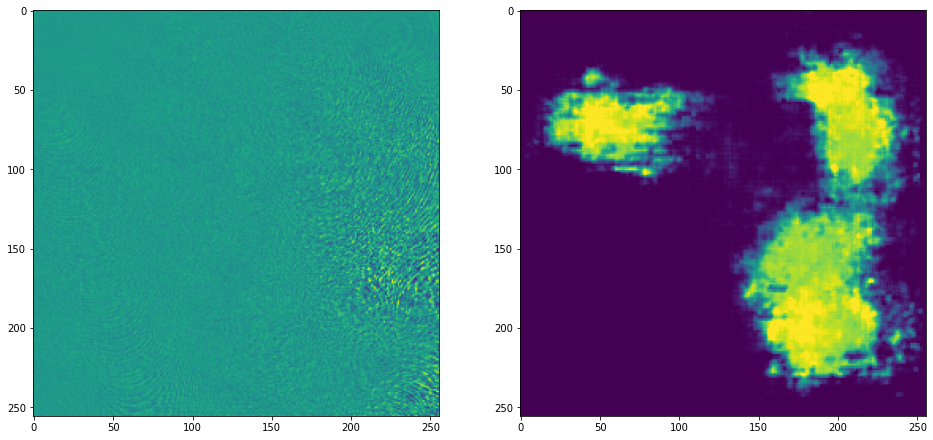

In [31]:
## Coin 
X = np.zeros((1, 256,256, 2))
m = sio.loadmat('test_coin_256.mat')['tmp2']
m = m / np.angle(m[0,0])
m = m / np.max(abs(m))
X[0,:,:,0] = np.real(m)
X[0,:,:,1] = np.imag(m) 

tmp = model.predict(X)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(X[0,:,:,0])
# plt.show()

# plt.subplot(1,3,2)
# plt.imshow(y[0,:,:,0],vmin = 0,vmax = 0.5)
# # plt.colorbar()
# # plt.show()

plt.subplot(1,2,2)
plt.imshow(tmp[0,:,:,0],vmin = 0,vmax = 0.5)
# plt.colorbar()
plt.show()